In [6]:
import pywt # type: ignore
from tsai.all import * # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from contextlib import contextmanager
import numpy as np # type: ignore
from sklearn.linear_model import LinearRegression # type: ignore
#from sktime.forecasting.arima import AutoARIMA
from sklearn.model_selection import train_test_split # type: ignore
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import AutoARIMA,ARIMA
from statsmodels.tsa.seasonal import MSTL,STL
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Mudar o diretório de trabalho
# Útil para acessar outras pastas com os.listdir() e afins
@contextmanager
def cwd(path: str) -> None:
    """path = Caminho do diretório de trabalho"""
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

# Função para decompor a série temporal
def wavelet_decompose(data, wavelet='haar',level=2):
    """ data = Série temporal
        wavelet = Wavelet a ser usada
        level = Nível de decomposição
        """
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return coeffs

# Função para previsão usando auto_arima para encontrar o melhor modelo
def forecast_arima(series, new_data,seasonal=False,m=1,arima_model:ARIMA = None):
    """
    trend = Série temporal
    new_data = Novos dados para atualizar o modelo
    """
    if not arima_model:
        arima_model = AutoARIMA(
            start_p=4, start_q=0, d=0, max_p=10, max_q=10, max_d=3, max_order=None,
            start_P=6, seasonal=seasonal, D=0, start_Q=1, max_P=10, max_D=2, max_Q=10,
            m=m, trace=True, error_action='ignore',
            suppress_warnings=True, stepwise=True, information_criterion='aic',
            scoring='mse', scoring_args=None, with_intercept='auto',
        )
    # Ajustar o modelo nos dados de treino
    arima_model = arima_model.fit(y=series)
    
    lista_previsoes = []
    
    for j in range(new_data.shape[0]): 
        # Cada new_data[j][0] é um array de 8 dias
        janela_8_dias = new_data[j, 0]
        
        # Prever os próximos 8 passos
        previsao = arima_model.predict(n_periods=8)
        
        # Adiciona os 8 passos previstos à lista
        lista_previsoes.append(previsao)
        
        # Atualiza o modelo apenas após armazenar a previsão
        arima_model = arima_model.update(janela_8_dias)
    
    forecast = np.array(lista_previsoes)
    return arima_model, forecast


def forecast_exponential_smoothing(series, new_data, trend='add', seasonal='add', seasonal_periods=7, initialization_method='heuristic'):
    """
    series: Série temporal de treinamento
    new_data: Novos dados para atualizar o modelo
    seasonal_periods: Período sazonal
    """
    # Ajuste do modelo Exponential Smoothing
    model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, initialization_method=initialization_method)
    model_fit = model.fit()

    # Lista para armazenar previsões
    lista_previsoes = []

    for j in range(new_data.shape[0]):
        # Prever os próximos 8 passos
        previsao = model_fit.forecast(steps=8)
        lista_previsoes.append(previsao)
        
        # Atualizar a série original com a janela atual de novos dados
        series = np.concatenate([series, new_data[j, 0]])
        
        # Refazer o ajuste com os dados atualizados
        model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, initialization_method=initialization_method)
        model_fit = model.fit()

    # Convertendo lista de previsões em numpy array
    forecast = np.array(lista_previsoes)
    
    return model_fit, forecast


# Inicializar e treinar a rede neural
def forecast_ann(X, y,splits,model = LSTMPlus, epochs=200,arch_config={}):
    """ X = Matriz de features (n° de observações, características, comprimento da série temporal)
        y = Variável target (n° de observações, comprimento da série temporal)
        splits = Índices de treino e validação
        X_test = Matriz de features de teste (n° de observações, características, comprimento da série temporal)
        model = Arquitetura da rede neural. Mais informações em https://timeseriesai.github.io/tsai/
        epochs = Número de épocas
        """
    learn = TSForecaster(X, y,splits=splits, arch=model, metrics=[mae, rmse],arch_config=arch_config, batch_tfms=TSStandardize(), tfms=[None, [TSForecasting()]], loss_func=HuberLoss(delta=1, reduction='mean')) # type: ignore
    #with ContextManagers([learn.no_logging(), learn.no_bar()]):
    lr = learn.lr_find() # Achar o melhor learning rate pro modelo, método da biblioteca fastai
    learn.fit_one_cycle(epochs, lr_max=lr.valley)
    print(f'Métricas de Treinamento para {model}')
    display(pd.Series(learn.recorder.values[-1], index=learn.recorder.metric_names[1:5]))
    raw_preds, target, _ = learn.get_X_preds(X[splits[2]],y[splits[2]])
    return raw_preds,target


# Carregar os dados
with cwd('./gpp_novo_2002_2021/'):
    csvs = sorted(os.listdir()) # Lista com os arquivos .csv
    dados = []
    for csv in csvs:
        region = csv.split('_')[1] # Nome da região
        df = pd.read_csv(csv, index_col='index', date_format='index').rename(columns={'GPP': region})
        df.index = pd.to_datetime(df.index)
        df = df.resample('D').mean() # Resample para preencher os dias faltantes e acrescentar frequência diária
        dados.append(df)
    df = pd.concat(dados, axis=1)

In [2]:
# Decomposição e previsão no Peru. Favor testar em outras regiões.
peru = df['peru'].copy()
santarem = df['santarem'].copy()
caxiuana = df['caxiuana'].copy()

In [ ]:
[2,29,40,44,61,191,194,195,275,359]

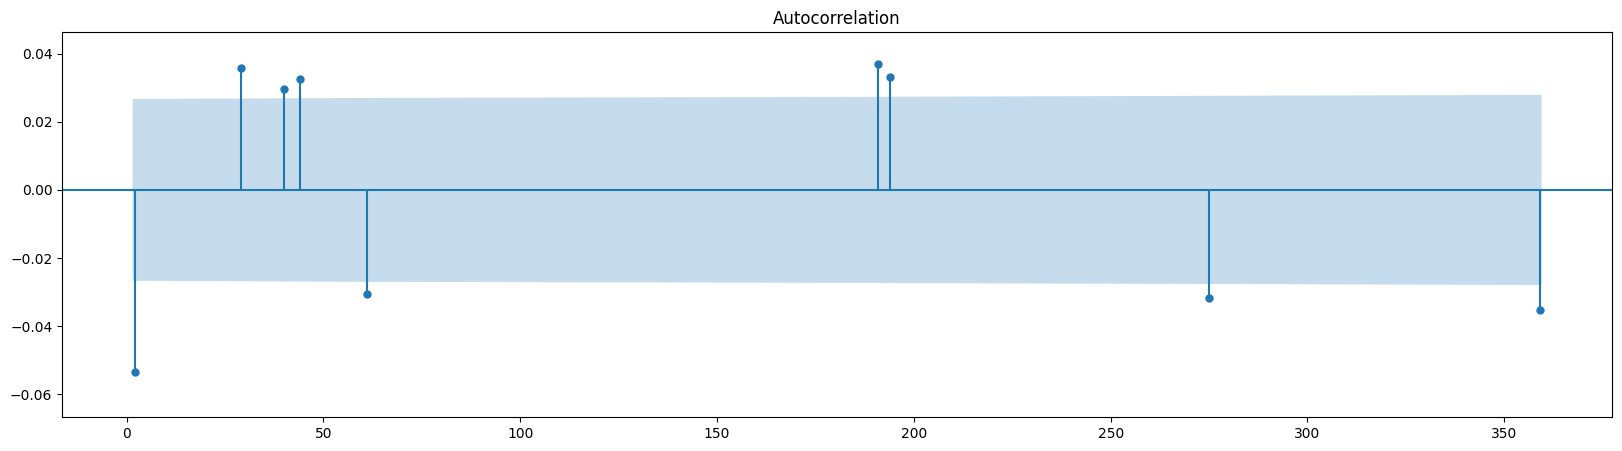

In [89]:
fig, ax = plt.subplots(figsize=(20, 5))
# Ajuste o número de lags plotados para uma visualização mais clara.
plot_acf(peru.diff().dropna().values.squeeze(), lags=[2,29,40,44,61,191,194,275,359], ax=ax,auto_ylims=True,zero=False)
plt.show()

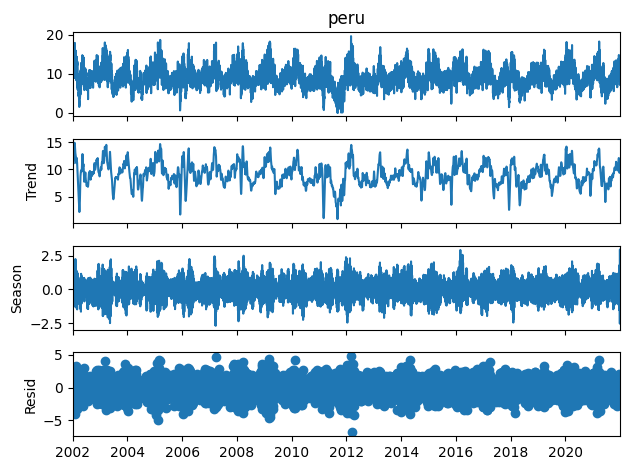

In [3]:
decomposed = STL(peru).fit()
decomposed.plot()
plt.tight_layout()
plt.show()

In [4]:
trend = decomposed.trend
seasonal = decomposed.seasonal
resid = decomposed.resid

train_loss    0.051909
valid_loss    0.057436
mae           0.259709
_rmse         0.339947
dtype: float64

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.263607,0.193923,0.506554,0.638494,00:03
1,0.237881,0.177522,0.484133,0.607092,00:03
2,0.223213,0.173677,0.477307,0.601117,00:03
3,0.211978,0.162240,0.459334,0.579789,00:04
4,0.198451,0.146793,0.434833,0.550361,00:03
5,0.179874,0.126643,0.402086,0.509761,00:03
6,0.155006,0.103263,0.357883,0.459320,00:03
7,0.127193,0.081296,0.310916,0.405853,00:03
8,0.106425,0.073805,0.294912,0.386348,00:03
9,0.095209,0.071578,0.290567,0.380512,00:03


Métricas de Treinamento para <class 'tsai.models.XceptionTimePlus.XceptionTimePlus'>


train_loss    0.052813
valid_loss    0.052187
mae           0.246545
_rmse         0.323764
dtype: float64

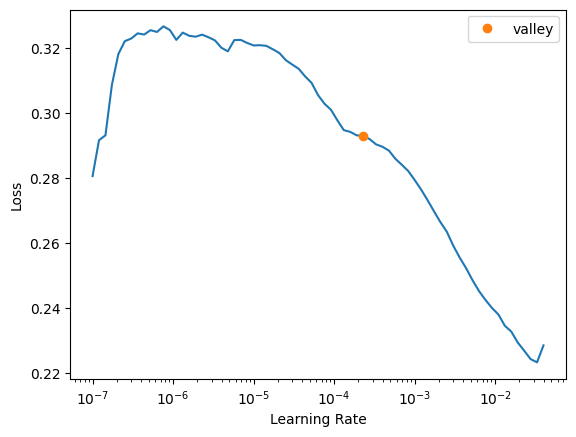

In [163]:
train_seasonal, test_seasonal = train_test_split(seasonal, test_size=0.15,shuffle=False)
train_seasonal, val_seasonal = train_test_split(train_seasonal, test_size=0.15,shuffle=False)
train_seasonal_x,train_seasonal_y = SlidingWindow(window_len=8,horizon=8,stride=2,seq_first=True)(train_seasonal.values)
val_seasonal_x,val_seasonal_y = SlidingWindow(window_len=8,horizon=8,stride=2,seq_first=True)(val_seasonal.values)
test_seasonal_x,test_seasonal_y = SlidingWindow(window_len=8,horizon=8,stride=None,seq_first=True)(test_seasonal.values)
X, y, splits = combine_split_data(xs=[train_seasonal_x,val_seasonal_x,test_seasonal_x],ys=[train_seasonal_y,val_seasonal_y,test_seasonal_y])
preds, target = forecast_ann(X,y,splits,model=XceptionTimePlus,epochs=100)

0.2655177857269842
0.35055452633954975


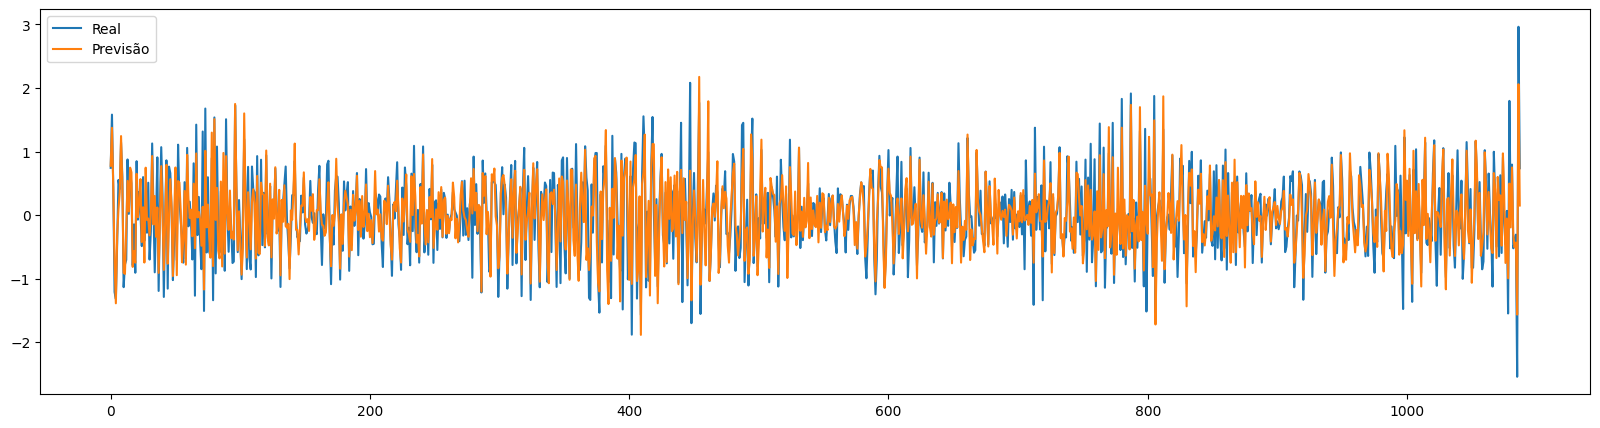

In [164]:
seasonal_preds = preds.flatten()
print(mean_absolute_error(test_seasonal_y.flatten(),preds.flatten()))
print(mean_squared_error(test_seasonal_y.flatten(),preds.flatten(),squared=False))
plt.figure(figsize=(20,5))
plt.plot(test_seasonal_y.flatten(),label='Real')
plt.plot(preds.flatten(), label='Previsão')
plt.legend()
plt.show()

In [ ]:
train_seasonal, test_seasonal = train_test_split(seasonal, test_size=0.15,shuffle=False)
seasonal_preds = []
arima, seasonal_forecast = forecast_arima(series=train_seasonal,new_data=test_seasonal[:'2021-12-23'].values.reshape(-1,1,8),seasonal=True,m=7)
print(arima.aic())
seasonal_preds.append(seasonal_forecast)
seasonal_preds = np.array(seasonal_preds)
print(mean_absolute_error(test_seasonal[:'2021-12-23'],seasonal_preds.flatten()))
print(mean_squared_error(test_seasonal[:'2021-12-23'],seasonal_preds.flatten(),squared=False))
plt.figure(figsize=(20,5))
plt.plot(test_seasonal[:'2021-12-23'],label='Real')
plt.plot(test_seasonal[:'2021-12-23'].index,seasonal_preds.flatten(), label='Previsão')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(4,0,0)(6,0,1)[7] intercept   : AIC=-1785.725, Time=145.23 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12911.134, Time=0.48 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5114.940, Time=1.73 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=12909.134, Time=0.20 sec
 ARIMA(4,0,0)(5,0,1)[7] intercept   : AIC=-1253.031, Time=131.14 sec
 ARIMA(4,0,0)(6,0,0)[7] intercept   : AIC=-1482.135, Time=88.38 sec
 ARIMA(4,0,0)(7,0,1)[7] intercept   : AIC=-1982.127, Time=199.10 sec
 ARIMA(4,0,0)(7,0,0)[7] intercept   : AIC=-1970.523, Time=163.48 sec
 ARIMA(4,0,0)(8,0,1)[7] intercept   : AIC=-2014.059, Time=423.41 sec
 ARIMA(4,0,0)(8,0,0)[7] intercept   : AIC=-1994.110, Time=254.18 sec
 ARIMA(4,0,0)(9,0,1)[7] intercept   : AIC=-2075.958, Time=1221.40 sec
 ARIMA(4,0,0)(9,0,0)[7] intercept   : AIC=-2071.785, Time=855.79 sec


In [183]:
train_seasonal, test_seasonal = train_test_split(seasonal, test_size=0.15,shuffle=False)
seasonal_preds = []
_, seasonal_forecast = forecast_exponential_smoothing(series=train_seasonal,new_data=test_seasonal[:'2021-12-23'].values.reshape(-1,1,8),seasonal='add',trend=None)
seasonal_preds.append(seasonal_forecast)
seasonal_preds = np.array(seasonal_preds)

0.33930708392663206
0.45649864910648985


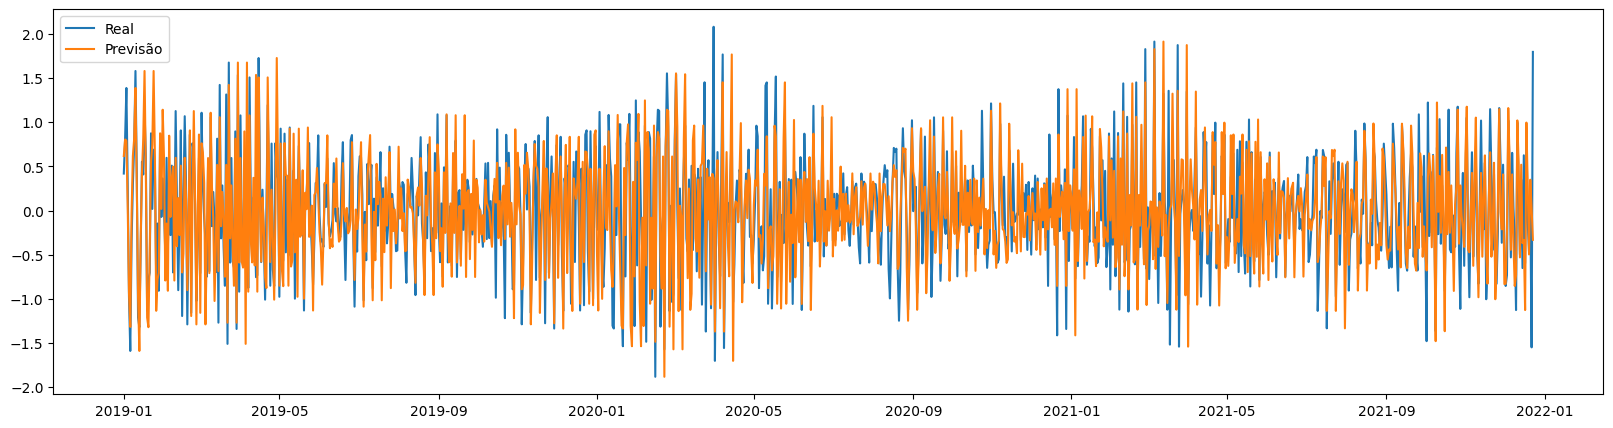

In [184]:
print(mean_absolute_error(test_seasonal[:'2021-12-23'],seasonal_preds.flatten()))
print(mean_squared_error(test_seasonal[:'2021-12-23'],seasonal_preds.flatten(),squared=False))
plt.figure(figsize=(20,5))
plt.plot(test_seasonal[:'2021-12-23'],label='Real')
plt.plot(test_seasonal[:'2021-12-23'].index,seasonal_preds.flatten(), label='Previsão')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-22515.693, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2585.738, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16018.139, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10480.074, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2587.737, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-24086.946, Time=1.28 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-25543.792, Time=1.61 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-25543.803, Time=3.52 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-25542.386, Time=6.37 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-25539.377, Time=12.50 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-25542.350, Time=9.04 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-25564.536, Time=15.78 sec
 ARIMA(7,1,1)(0,0,0)[0] intercept   : AIC=-25638.173, Time=17.08 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-26321.213, Time=3.13 sec
 ARI

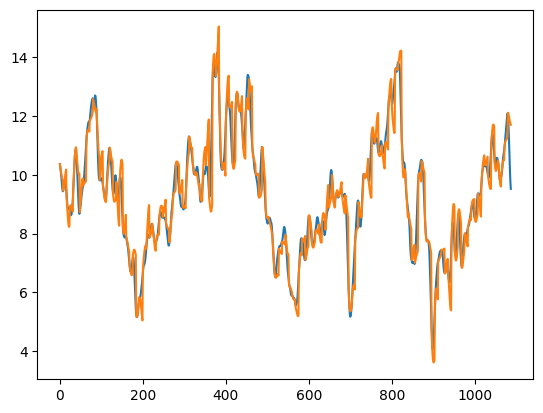

In [172]:
train_trend, test_trend = train_test_split(trend, test_size=0.15,shuffle=False)
arima_model, trend_forecast = forecast_arima(series=train_trend,new_data=test_trend[:'2021-12-23'].values.reshape(-1,1,8),)
plt.plot(test_trend[:'2021-12-23'].values)
plt.plot(trend_forecast.flatten())
print(mean_squared_error(test_trend[:'2021-12-23'].values,trend_forecast.flatten(),squared=False))
print(mean_absolute_error(test_trend[:'2021-12-23'].values,trend_forecast.flatten()))

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.510817,0.455875,0.824640,1.066668,00:03
1,0.496598,0.429048,0.797426,1.023605,00:02
2,0.486640,0.421419,0.791666,1.008861,00:02
3,0.483433,0.420605,0.787850,1.008551,00:02
4,0.478979,0.416977,0.785310,1.001451,00:03
5,0.475598,0.413685,0.780340,0.997974,00:03
6,0.473544,0.414130,0.782108,0.997842,00:02
7,0.469846,0.413030,0.777831,0.998035,00:02
8,0.464388,0.410001,0.777424,0.988593,00:02
9,0.458078,0.397537,0.759761,0.973607,00:03


Métricas de Treinamento para <class 'tsai.models.RNNAttention.LSTMAttention'>


train_loss    0.366280
valid_loss    0.388590
mae           0.744919
_rmse         0.963550
dtype: float64

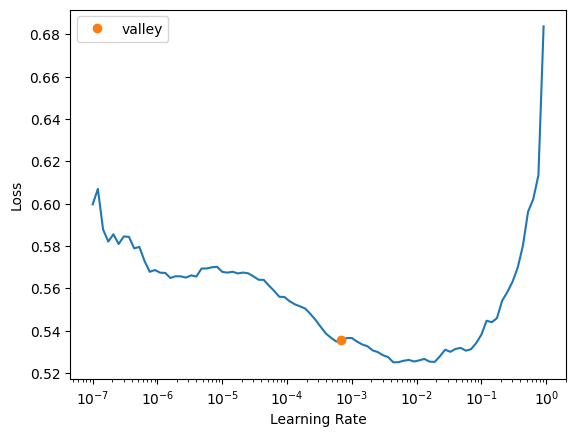

In [157]:
train_residual, test_residual = train_test_split(resid, test_size=0.15,shuffle=False)
train_residual, val_residual = train_test_split(train_residual, test_size=0.15,shuffle=False)
train_residual_x,train_residual_y = SlidingWindow(window_len=8,horizon=8,stride=2,seq_first=True)(train_residual.values)
val_residual_x,val_residual_y = SlidingWindow(window_len=8,horizon=8,stride=2,seq_first=True)(val_residual.values)
test_residual_x,test_residual_y = SlidingWindow(window_len=8,horizon=8,stride=None,seq_first=True)(test_residual.values)
X, y, splits = combine_split_data(xs=[train_residual_x,val_residual_x,test_residual_x],ys=[train_residual_y,val_residual_y,test_residual_y])
preds, target = forecast_ann(X,y,splits,model=LSTMAttention,epochs=50)

In [147]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

final_pred = preds.numpy().flatten() + trend_forecast.flatten() + seasonal_preds[0].flatten() + seasonal_preds[1].flatten()
real_values = test_residual[:'2021-12-23'] + test_trend[:'2021-12-23'] + test_seasonal.iloc[:, 0][:'2021-12-23'].values.flatten() + test_seasonal.iloc[:, 1][:'2021-12-23'].values.flatten()
print(mean_squared_error(real_values,final_pred,squared=False))
print(mean_absolute_error(real_values,final_pred))
print(r2_score(real_values,final_pred))
print(mean_absolute_percentage_error(real_values,final_pred))
print(np.corrcoef(real_values,final_pred)[0,1])
plt.figure(figsize=(20,5))
plt.plot(real_values)
plt.plot(real_values.index,final_pred)
plt.tight_layout()
plt.show()

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [193]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

final_pred = preds.flatten() + seasonal_preds.flatten() + trend_forecast.flatten() #seasonal.shift(8).dropna()[test_trend[:'2021-12-23'].index].values + trend_forecast.flatten()
real_values = test_residual[:'2021-12-23'] + test_trend[:'2021-12-23'] + seasonal[test_trend[:'2021-12-23'].index]
final_pred = final_pred.numpy()

print(mean_squared_error(real_values,final_pred,squared=False))
print(mean_absolute_error(real_values,final_pred))
print(r2_score(real_values,final_pred))
print(mean_absolute_percentage_error(real_values,final_pred))
print(np.corrcoef(real_values,final_pred)[0,1])

1.716693928778737
1.3121145509763839
0.5008649116140476
0.14953578964069725
0.7430971363202258


In [186]:
preds_residuals = final_pred - real_values
residuos = pd.Series(preds_residuals,index=real_values.index)
residuos.describe()

count    1088.000000
mean       -0.007963
std         1.489611
min        -5.921149
25%        -0.950614
50%        -0.013262
75%         0.954924
max         5.623602
dtype: float64

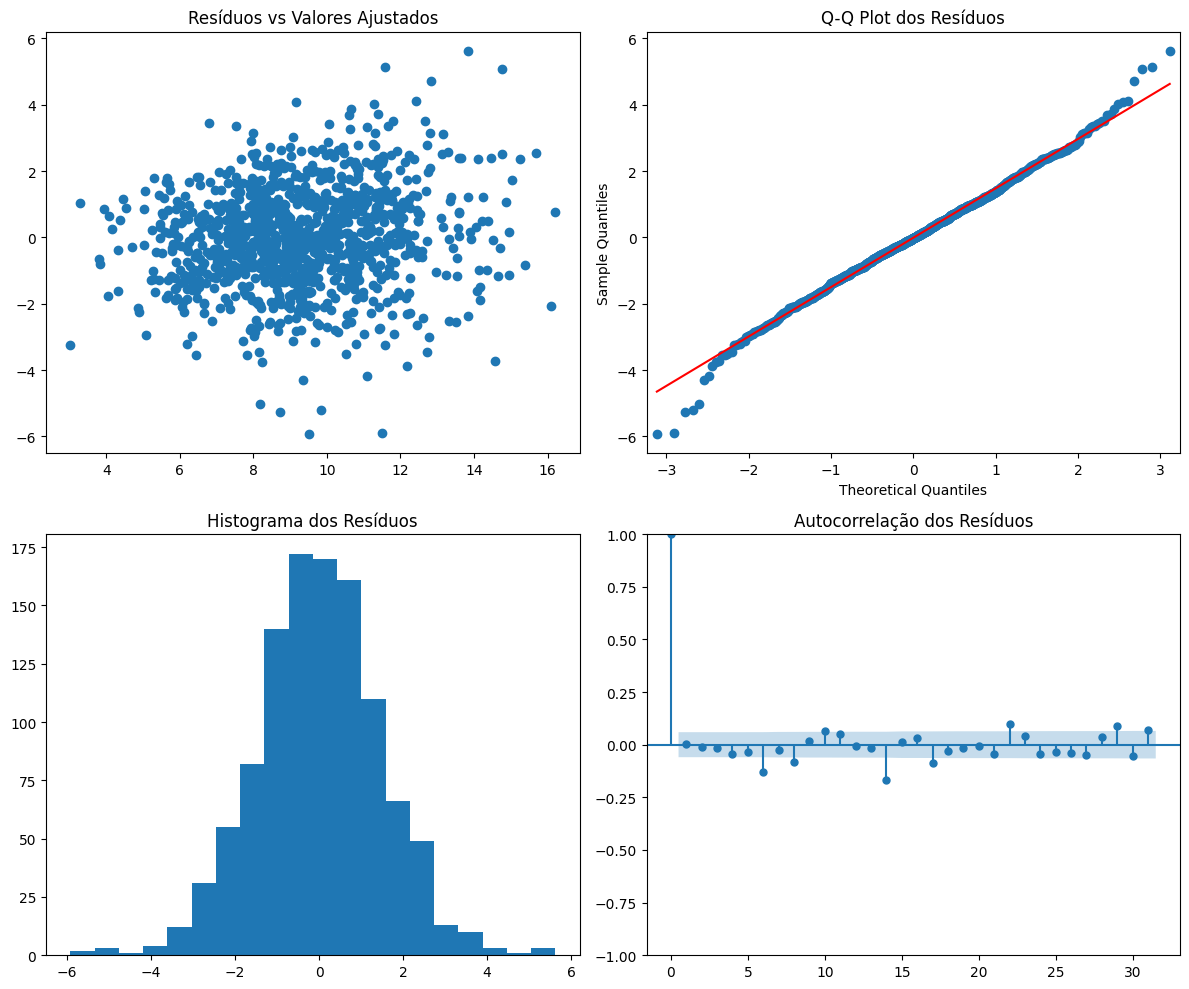

In [187]:
import statsmodels.api as sm

# Valores ajustados fictícios para ilustrar (geralmente não disponíveis apenas com resíduos)
valores_ajustados = final_pred

# Gráficos de análise de resíduos
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Gráfico dos resíduos versus valores ajustados (valores fictícios)
axes[0, 0].scatter(valores_ajustados, preds_residuals)
axes[0, 0].set_title('Resíduos vs Valores Ajustados')

# Q-Q plot dos resíduos para verificar normalidade
sm.qqplot(preds_residuals, line='s', ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot dos Resíduos')

# Histograma dos resíduos
axes[1, 0].hist(preds_residuals, bins=20)
axes[1, 0].set_title('Histograma dos Resíduos')

# Gráfico de autocorrelação dos resíduos
plot_acf(preds_residuals, ax=axes[1, 1])
axes[1, 1].set_title('Autocorrelação dos Resíduos')

plt.tight_layout()
plt.show()

In [190]:
from scipy.stats import shapiro

stat, p_value = shapiro(preds_residuals)

# Interpretação do teste de Shapiro-Wilk
alpha = 0.05  # Nível de significância
print(f'Estatística de teste: {stat:.4f}, p-valor: {p_value:.4f}')

if p_value > alpha:
    print('Os resíduos parecem seguir uma distribuição normal (não rejeitamos H0)')
else:
    print('Os resíduos não parecem seguir uma distribuição normal (rejeitamos H0)')

Estatística de teste: 0.9950, p-valor: 0.0012
Os resíduos não parecem seguir uma distribuição normal (rejeitamos H0)


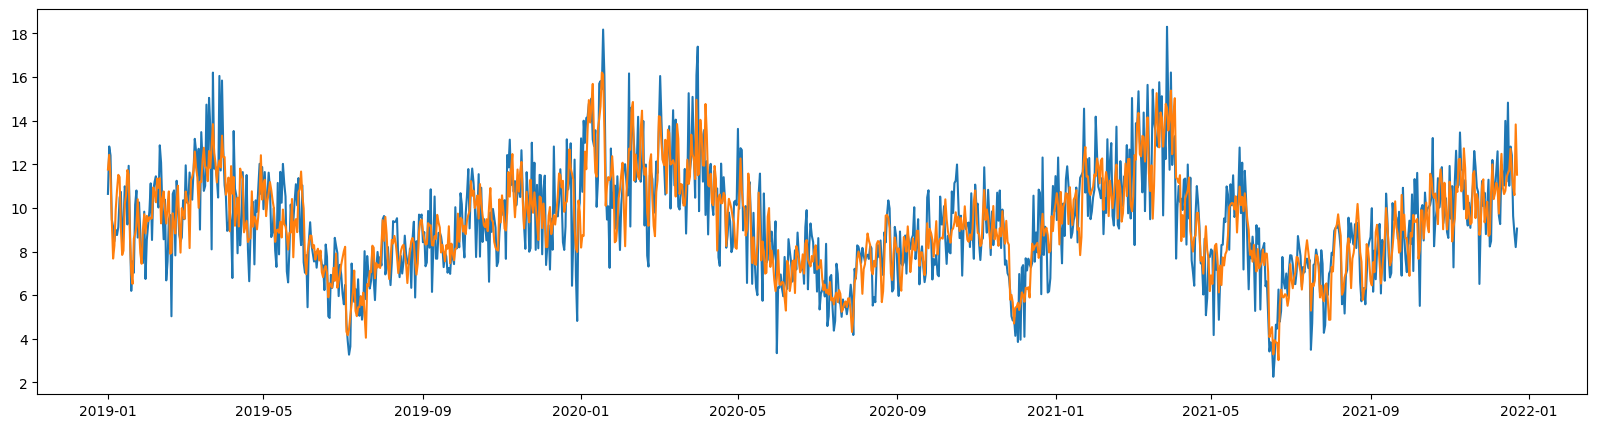

In [189]:
plt.figure(figsize=(20,5))
plt.plot(real_values.index,real_values)
plt.plot(real_values.index,final_pred)